In [19]:

# Importações das bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io  # Para carregar imagens de URLs
from sklearn.utils import shuffle
import warnings

# Ignorar avisos futuros do K-means sobre n_init
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.cluster._kmeans')

# Função auxiliar para carregar e exibir as imagens originais
def carregar_imagens(urls_imagens):
    """Carrega imagens de uma lista de URLs e as exibe."""
    imagens = {}
    plt.figure(figsize=(15, 5))

    for i, (nome, url) in enumerate(urls_imagens.items()):
        print(f"Baixando imagem: {nome}...")
        try:
            img = io.imread(url)
            # Garantir que a imagem está em RGB (remover canal alfa, se houver)
            if img.shape[-1] == 4:
                img = img[..., :3]
            imagens[nome] = img

            plt.subplot(1, len(urls_imagens), i + 1)
            plt.imshow(img)
            plt.title(nome)
            plt.axis('off')
        except Exception as e:
            print(f"Erro ao carregar {nome}: {e}")
            imagens[nome] = None

    plt.suptitle("Imagens de Teste Originais", fontsize=16)
    plt.show()
    return imagens

# Função auxiliar para plotar comparações
def plotar_comparacao(original, resultado1, resultado2, titulo1, titulo2, fig_size=(18, 6)):
    """Exibe três imagens lado a lado: Original, Método 1, Método 2."""
    plt.figure(figsize=fig_size)

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Imagem Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(resultado1)
    plt.title(titulo1)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Otsu geralmente retorna uma máscara (2D), então usamos cmap='gray'
    if resultado2.ndim == 2:
        plt.imshow(resultado2, cmap='gray')
    else:
        plt.imshow(resultado2)
    plt.title(titulo2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()



Carregando imagens a partir dos caminhos de arquivo especificados:
Carregando imagem: Frutas...
Carregando imagem: Praia...
Carregando imagem: Mulher...


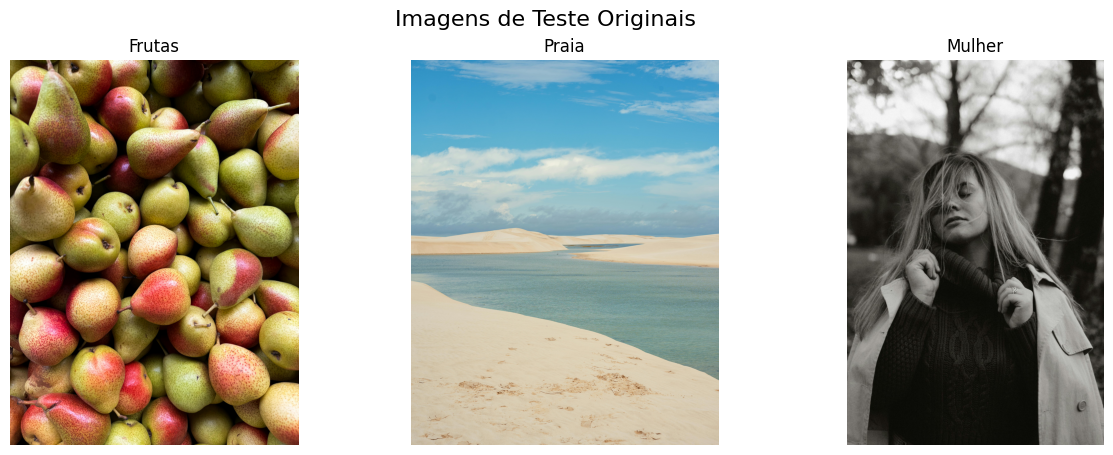

In [20]:
# 3. CARREGAMENTO DAS IMAGENS DE TESTE (VIA CAMINHO DE ARQUIVO LOCAL)

caminhos_imagens = {
    "Frutas": "img/frutas.jpg",
    "Praia": "img/praia.jpg",
    "Mulher": "img/mulher.jpg"
}

print("Carregando imagens a partir dos caminhos de arquivo especificados:")

imagens = {}
plt.figure(figsize=(15, 5))

for i, (nome, caminho) in enumerate(caminhos_imagens.items()):
    print(f"Carregando imagem: {nome}...")
    try:
        img = cv2.imread(caminho)
        # OpenCV carrega em BGR por padrão, converter para RGB para exibição com matplotlib
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imagens[nome] = img

            plt.subplot(1, len(caminhos_imagens), i + 1)
            plt.imshow(img)
            plt.title(nome)
            plt.axis('off')
        else:
            print(f"Erro ao carregar {nome}: Arquivo não encontrado ou inválido.")
            imagens[nome] = None
    except Exception as e:
        print(f"Erro ao carregar {nome}: {e}")
        imagens[nome] = None

plt.suptitle("Imagens de Teste Originais", fontsize=16)
plt.show()

In [21]:
# 4. IMPLEMENTAÇÃO DAS FUNÇÕES DE SEGMENTAÇÃO

def segmentar_kmeans(imagem, k=3):
    """
    Segmenta uma imagem usando K-means.

    Para eficiência, usamos uma amostra de pixels se a imagem for muito grande.
    """
    # 1. Preparar os dados
    # Converter a imagem em uma lista de pixels (vetores RGB)
    pixels = imagem.reshape((-1, 3))

    # Se a imagem for muito grande, usar uma amostragem para treinar o K-means
    # Isso acelera muito o processo sem grande perda de qualidade
    if pixels.shape[0] > 100000:
        pixels_amostra = shuffle(pixels, random_state=42, n_samples=100000)
    else:
        pixels_amostra = pixels

    # 2. Treinar o modelo K-means
    # n_init=10 executa o algoritmo 10x com centroides diferentes e escolhe o melhor
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=200)
    kmeans.fit(pixels_amostra)

    # 3. Prever os clusters para TODOS os pixels
    labels = kmeans.predict(pixels)

    # 4. Recriar a imagem
    # Substituir cada pixel pela cor do centroide do seu cluster
    centroides = kmeans.cluster_centers_
    segmentada = centroides[labels]

    # 5. Remodelar para o formato original da imagem
    segmentada = segmentada.reshape(imagem.shape)

    return segmentada.astype(np.uint8)


def segmentar_otsu(imagem):
    """
    Segmenta uma imagem usando o método de Otsu.
    Retorna a máscara binária e a imagem original mascarada.
    """
    # 1. Converter para escala de cinza (Otsu opera em histograma de 1D)
    try:
        gray = cv2.cvtColor(imagem, cv2.COLOR_RGB2GRAY)
    except cv2.error:
        # Imagem já pode estar em escala de cinza
        gray = imagem

    # 2. Aplicar o limiar de Otsu
    # cv2.THRESH_OTSU calcula automaticamente o limiar
    # O primeiro valor (thresh_val) é o limiar encontrado, não precisamos dele aqui.
    thresh_val, mascara = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Aplicar a máscara à imagem original (opcional, mas bom para visualização)
    # segmentada = cv2.bitwise_and(imagem, imagem, mask=mascara)

    # Vamos retornar a máscara binária para uma comparação mais clara
    return mascara

print("Funções de segmentação K-means e Otsu definidas.")

Funções de segmentação K-means e Otsu definidas.


Iniciando Experimento 1: Frutas
Executando K-means com k=5...
K-means concluído.
Executando Otsu...
Otsu concluído.


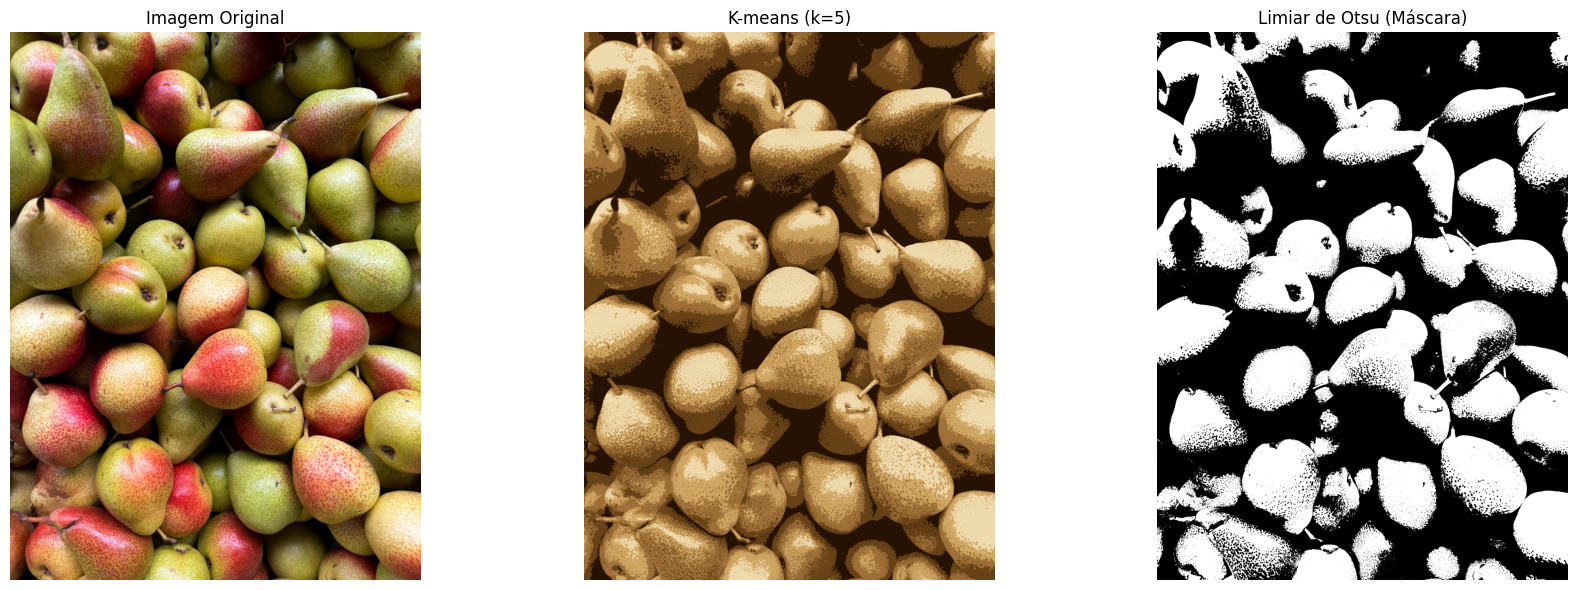

In [22]:


print("Iniciando Experimento 1: Frutas")
img_natural = imagens.get("Frutas")

if img_natural is not None:
    # Definir o número de clusters para o K-means
    # Queremos separar: Céu, Balão (talvez 2 cores), Vegetação, Chão. k=4 ou k=5.
    k_natural = 5
    print(f"Executando K-means com k={k_natural}...")
    kmeans_natural = segmentar_kmeans(img_natural, k=k_natural)
    print("K-means concluído.")

    # Executar Otsu
    print("Executando Otsu...")
    otsu_natural = segmentar_otsu(img_natural)
    print("Otsu concluído.")

    # Plotar resultados
    plotar_comparacao(
        img_natural,
        kmeans_natural,
        otsu_natural,
        f"K-means (k={k_natural})",
        "Limiar de Otsu (Máscara)"
    )
else:
    print("Imagem 'Frutas' não carregada. Pulando experimento.")

Iniciando Experimento 2: Praia
Executando K-means com k=2...
K-means concluído.
Executando Otsu...
Otsu concluído.


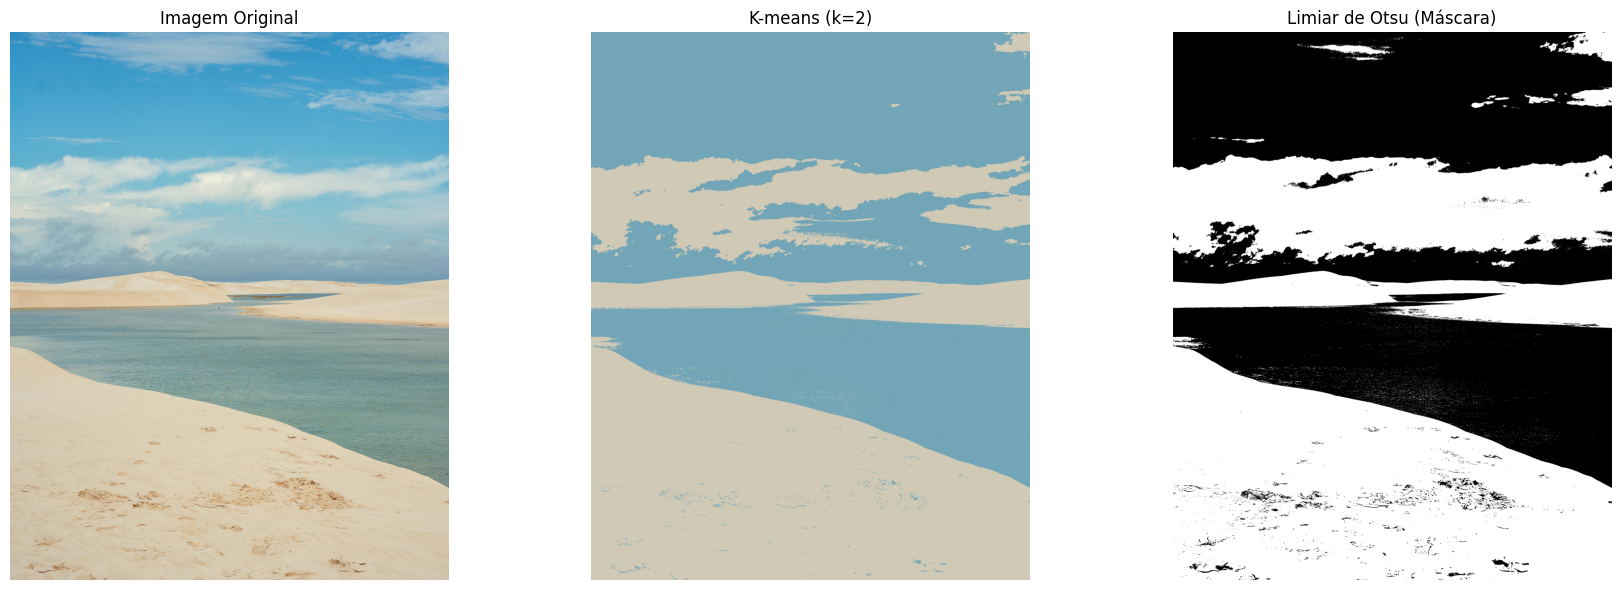

In [23]:


print("Iniciando Experimento 2: Praia")
img_medica = imagens.get("Praia") # Use .get() para evitar KeyError se a imagem não foi carregada

if img_medica is not None:
    # K-means: Queremos separar as células do fundo. k=2.
    k_medica = 2
    print(f"Executando K-means com k={k_medica}...")
    kmeans_medica = segmentar_kmeans(img_medica, k=k_medica)
    print("K-means concluído.")

    # Otsu
    print("Executando Otsu...")
    otsu_medica = segmentar_otsu(img_medica)
    print("Otsu concluído.")

    # Plotar resultados
    plotar_comparacao(
        img_medica,
        kmeans_medica,
        otsu_medica,
        f"K-means (k={k_medica})",
        "Limiar de Otsu (Máscara)"
    )
else:
    print("Imagem 'Imagem da Praia' não carregada. Pulando experimento.")

Iniciando Experimento 3: Mulher
Executando K-means com k=6...
K-means concluído.
Executando Otsu...
Otsu concluído.


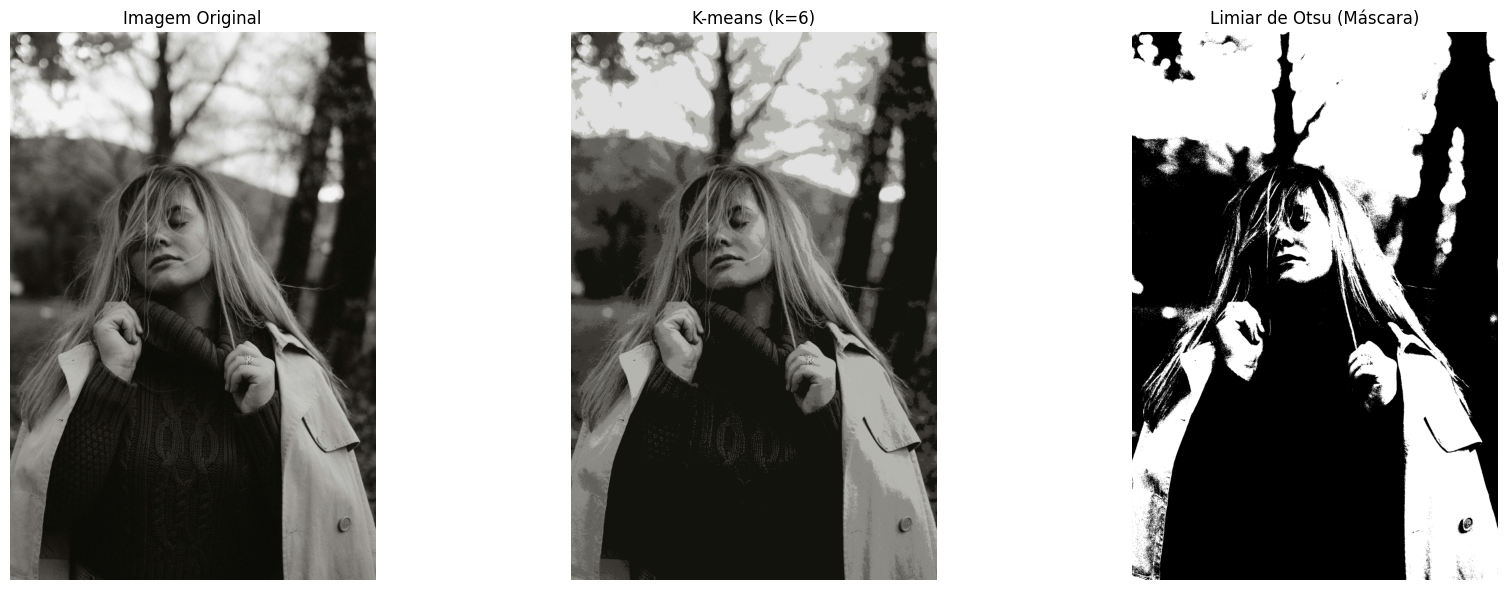

In [24]:


print("Iniciando Experimento 3: Mulher")
img_industrial = imagens.get("Mulher")

if img_industrial is not None:
    # K-means: Imagem complexa. Vamos tentar agrupar as cores principais.
    # Placa (verde), Slots (azul/preto), Componentes metálicos, etc. k=6
    k_industrial = 6
    print(f"Executando K-means com k={k_industrial}...")
    kmeans_industrial = segmentar_kmeans(img_industrial, k=k_industrial)
    print("K-means concluído.")

    # Otsu
    print("Executando Otsu...")
    otsu_industrial = segmentar_otsu(img_industrial)
    print("Otsu concluído.")

    # Plotar resultados
    plotar_comparacao(
        img_industrial,
        kmeans_industrial,
        otsu_industrial,
        f"K-means (k={k_industrial})",
        "Limiar de Otsu (Máscara)"
    )
else:
    print("Imagem 'Mulher' não carregada. Pulando experimento.")





#